# Getting Started with Qiskit

Here, we provide an overview of working with Qiskit.  The fundamental package of Qiskit is Terra that provides the basic building blocks necessary to program quantum computers. The fundamental unit of Qiskit is the [quantum circuit](https://en.wikipedia.org/wiki/Quantum_circuit). A basic workflow using Qiskit consists of two stages: **Build** and **Execute**. **Build** allows you to make different quantum circuits that represent the problem you are solving, and **Execute** that allows you to run them on different backends.  After the jobs have been run, the data is collected and postprocessed depending on the desired output.

In [1]:
import numpy as np
from qiskit import *

## Circuit Basics <a name='basics'></a>


### Building the circuit

The basic element needed for your first program is the QuantumCircuit.  We begin by creating a `QuantumCircuit` comprised of three qubits.

In [2]:
# Create a Quantum Circuit acting on a quantum register of three qubits
circ = QuantumCircuit(3)

After you create the circuit with its registers, you can add gates ("operations") to manipulate the registers. As you proceed through the tutorials you will find more gates and circuits; below is an example of a quantum circuit that makes a three-qubit GHZ state

$$|\psi\rangle = \left(|000\rangle+|111\rangle\right)/\sqrt{2}.$$

To create such a state, we start with a three-qubit quantum register. By default, each qubit in the register is initialized to $|0\rangle$. To make the GHZ state, we apply the following gates:
- A Hadamard gate $H$ on qubit 0, which puts it into the superposition state $\left(|0\rangle+|1\rangle\right)/\sqrt{2}$.
- A controlled-Not operation ($C_{X}$) between qubit 0 and qubit 1.
- A controlled-Not operation between qubit 0 and qubit 2.

On an ideal quantum computer, the state produced by running this circuit would be the GHZ state above.

In Qiskit, operations can be added to the circuit one by one, as shown below.

In [3]:
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 2, putting
# the qubits in a GHZ state.
circ.cx(0, 2)

## Visualize Circuit <a name='visualize'></a>

You can visualize your circuit using Qiskit `QuantumCircuit.draw()`, which plots the circuit in the form found in many textbooks.

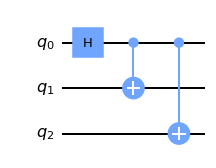

In [4]:
circ.draw('mpl')

In this circuit, the qubits are put in order, with qubit zero at the top and qubit two at the bottom. The circuit is read left to right (meaning that gates that are applied earlier in the circuit show up further to the left).

<div class="alert alert-block alert-info">


When representing the state of a multi-qubit system, the tensor order used in Qiskit is different than that used in most physics textbooks. Suppose there are $n$ qubits, and qubit $j$ is labeled as $Q_{j}$. Qiskit uses an ordering in which the $n^{\mathrm{th}}$ qubit is on the <em><strong>left</strong></em> side of the tensor product, so that the basis vectors are labeled as  $Q_{n-1}\otimes \cdots  \otimes  Q_1\otimes Q_0$.

For example, if qubit zero is in state 0, qubit 1 is in state 0, and qubit 2 is in state 1, Qiskit would represent this state as $|100\rangle$, whereas many physics textbooks would represent it as $|001\rangle$.

This difference in labeling affects the way multi-qubit operations are represented as matrices. For example, Qiskit represents a controlled-X ($C_{X}$) operation with qubit 0 being the control and qubit 1 being the target as

$$C_X = \begin{pmatrix} 1 & 0 & 0 & 0 \\  0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\\end{pmatrix}.$$

</div>

## Simulating circuits using Qiskit Aer <a name='simulation'></a>

Qiskit Aer is our package for simulating quantum circuits. It provides many different backends for doing a simulation. There is also a basic, Python only, implementation called `BasicAer` in Terra that can be used as a drop-in replacement for `Aer` in the examples below.

### Statevector backend

The most common backend in Qiskit Aer is the `statevector_simulator`. This simulator returns the quantum state, which is a complex vector of dimensions $2^n$, where $n$ is the number of qubits (so be careful using this as it will quickly get too large to run on your machine).

To run the above circuit using the statevector simulator, first you need to import Aer and then set the backend to `statevector_simulator`.

In [5]:
# Import Aer
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')

Now that we have chosen the backend, it's time to compile and run the quantum circuit. In Qiskit we provide the `execute` function for this. ``execute`` returns a ``job`` object that encapsulates information about the job submitted to the backend.


<div class="alert alert-block alert-info">
<b>Tip:</b> You can obtain the above parameters in Jupyter. Simply place the text cursor on a function and press Shift+Tab.
</div>

In [6]:
# Create a Quantum Program for execution 
job = backend.run(circ)

When you run a program, a job object is made that has the following two useful methods: 
`job.status()` and `job.result()`, which return the status of the job and a result object, respectively.

<div class="alert alert-block alert-info">
<b>Note:</b> Jobs run asynchronously, but when the result method is called, it switches to synchronous and waits for it to finish before moving on to another task.
</div>

In [7]:
result = job.result()

The results object contains the data and Qiskit provides the method 
`result.get_statevector(circ)` to return the state vector for the quantum circuit.

In [8]:
outputstate = result.get_statevector(circ, decimals=3)
print(outputstate)

[ 0.707+0.j -0.   +0.j  0.   +0.j -0.   +0.j  0.   +0.j -0.   +0.j
  0.   +0.j  0.707+0.j]


Qiskit also provides a visualization toolbox to allow you to view these results.

Below, we use the visualization function to plot the real and imaginary components of the state density matrix $\rho$.


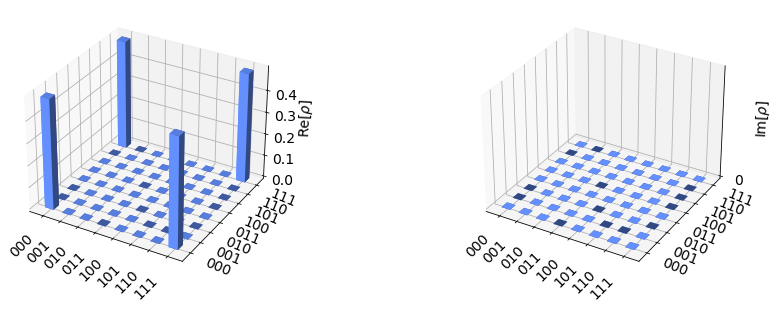

In [9]:
from qiskit.visualization import plot_state_city
plot_state_city(outputstate)

### OpenQASM backend

The state vecter simulators is useful because it provides information about the state output by the ideal circuit. However, a real experiment terminates by _measuring_ each qubit (usually in the computational $|0\rangle, |1\rangle$ basis). Without measurement, we cannot gain information about the state. Measurements cause the quantum system to collapse into classical bits. 

For example, suppose we make independent measurements on each qubit of the three-qubit GHZ state

$$|\psi\rangle = (|000\rangle +|111\rangle)/\sqrt{2},$$

and let $xyz$ denote the bitstring that results. Recall that, under the qubit labeling used by Qiskit, $x$ would correspond to the outcome on qubit 2, $y$ to the outcome on qubit 1, and $z$ to the outcome on qubit 0. 

<div class="alert alert-block alert-info">
<b>Note:</b> This representation of the bitstring puts the most significant bit (MSB) on the left, and the least significant bit (LSB) on the right. This is the standard ordering of binary bitstrings. We order the qubits in the same way (qubit representing the MSB has index 0), which is why Qiskit uses a non-standard tensor product order.
</div>

Recall the probability of obtaining outcome $xyz$ is given by

$$\mathrm{Pr}(xyz) = |\langle xyz | \psi \rangle |^{2}$$

and as such for the GHZ state probability of obtaining 000 or 111 are both 1/2.

To simulate a circuit that includes measurement, we need to add measurements to the original circuit above, and use a different Aer backend.

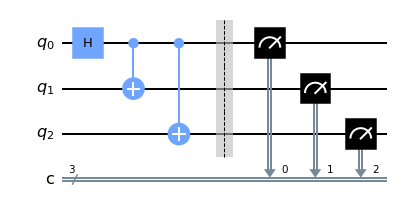

In [11]:
# Create a Quantum Circuit
meas = QuantumCircuit(3, 3)
meas.barrier(range(3))
# map the quantum measurement to the classical bits
meas.measure(range(3), range(3))

# The Qiskit circuit object supports composition using
# the addition operator.
circ.add_register(meas.cregs[0])
qc = circ.compose(meas)

#drawing the circuit
qc.draw(output="mpl")

This circuit adds a classical register, and three measurements that are used to map the outcome of qubits to the classical bits. 

To simulate this circuit, we use the ``qasm_simulator`` in Qiskit Aer. Each run of this circuit will yield either the bitstring 000 or 111. To build up statistics about the distribution of the bitstrings (to, e.g., estimate $\mathrm{Pr}(000)$), we need to repeat the circuit many times. The number of times the circuit is repeated can be specified in the ``execute`` function, via the ``shots`` keyword.

In [12]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

Once you have a result object, you can access the counts via the function `get_counts(circuit)`. This gives you the _aggregated_ binary outcomes of the circuit you submitted.

In [13]:
counts = result_sim.get_counts(qc)
print(counts)

{'111': 500, '000': 524}


Approximately 50 percent of the time, the output bitstring is 000. Qiskit also provides a function `plot_histogram`, which allows you to view the outcomes. 

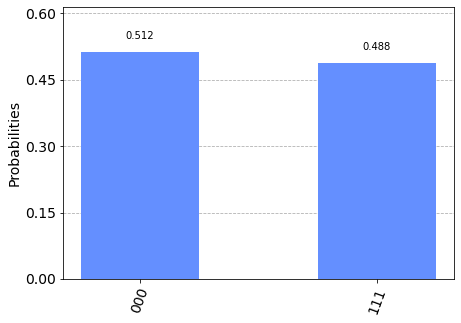

In [14]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

The estimated outcome probabilities Pr(000) and Pr(111) are computed by taking the aggregate counts and dividing by the number of shots (times the circuit was repeated).

## Executing circuits on IBM Quantum Systems <a name='execution'></a>


In [15]:
# Load your IBM Quantum account
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-melbourne', group='teaching', project='default')

In [16]:
# Select all operational devices with more than 2 qubits
backends_sel = provider.backends(filters=lambda x:not x.configuration().simulator and 
                                x.configuration().n_qubits >=2 and x.status().operational==True)
backends_sel

[<IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-melbourne', group='teaching', project='default')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-melbourne', group='teaching', project='default')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-melbourne', group='teaching', project='default')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-melbourne', group='teaching', project='default')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-melbourne', group='teaching', project='default')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q-melbourne', group='teaching', project='default')>]

In [17]:
# Select the device with the shortest queue
from qiskit.providers.ibmq import least_busy

backend = least_busy(backends_sel)
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-melbourne', group='teaching', project='default')>

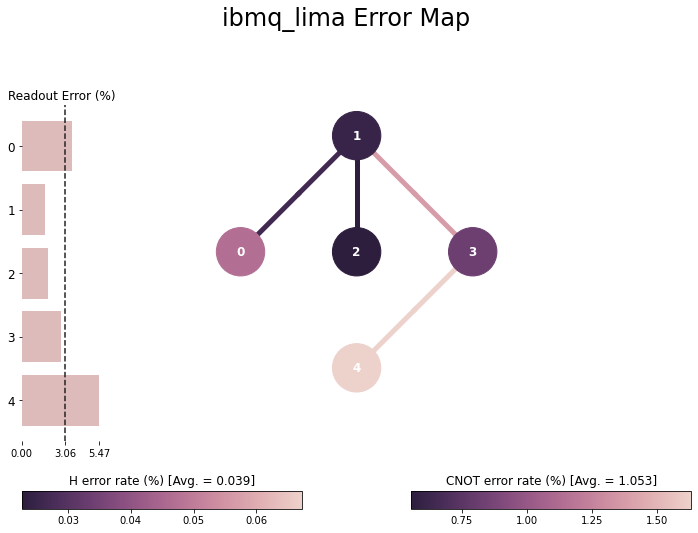

In [18]:
# View the error map of the selected device
from qiskit.visualization import *

plot_error_map(backend)

### Execute GHZ state on the chosen quantum system

In [19]:
from qiskit.tools.monitor import job_monitor

job = execute(qc, backend)
job_monitor(job)

Job Status: job has successfully run


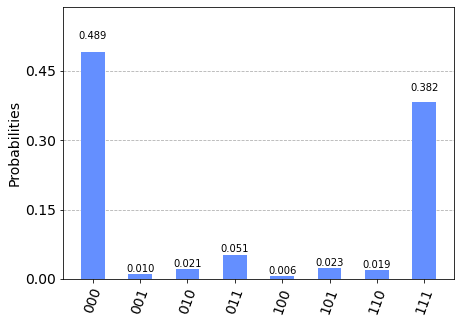

In [20]:
counts = job.result().get_counts()
plot_histogram(counts)

We see the results aren't the same as the simulator, and this is due to the noise in the quantum hardware.

The affect of this noise is actually more than it would seem, as the actual circuit being on the hardware is more than three gates due to the topology of the chip. 

To see what actual circuit was run on the backend, we can explicitly transpile it ourselves.

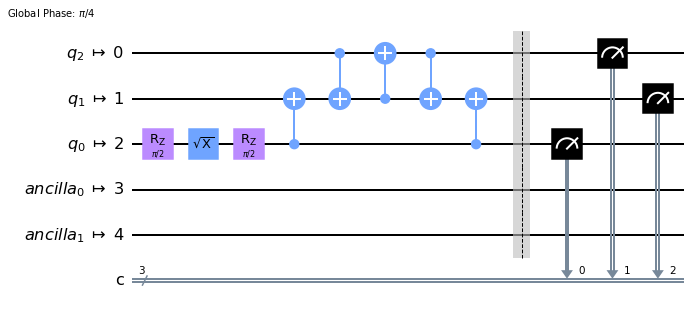

In [21]:
transpiled_circuit = transpile(qc, backend)
transpiled_circuit.draw(output="mpl")

We can also see which qubits the circuit was run on.

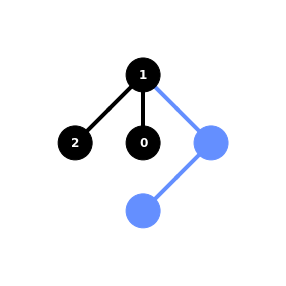

In [22]:
plot_circuit_layout(transpile(qc, backend), backend)

<div class="alert alert-block alert-success">

**Exercise**

1. Create a circuit: [INSERT CIRCUIT DIAGRAM HERE]
2. Simulate the circuit and plot results
3. Execute the circuit and plot results
    
</div>